In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
from scipy import polyfit, polyval
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
taxi_zones = gpd.read_file("../../Data/taxi_zones/taxi_zones_updated.shp")
boro = taxi_zones[['LocationID', 'borough']]

In [4]:
bk_d = [17,  25,  33, 49,  40,  34, 52, 54, 65, 106, 97, 66, 181, 189, 190, 195]

# Subway

In [5]:
def fourierExtrapolation(x, n_predict):
    n = len(x)
    # number of harmonics in model
    n_harm = 40             
    t = np.arange(0, n)
    # find linear trend in x
    p = np.polyfit(t, x, 1)         
    # remove the trend
    x_notrend = x - p[0] * t        
    # x with no trend in frequency domain
    x_freqdom = np.fft.fft(x_notrend)  
    # calculating frequencies
    f = np.fft.fftfreq(n)              
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda z: np.absolute(f[z]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        # get amplitude
        ampli = np.absolute(x_freqdom[i]) / n   
        # get phase
        phase = np.angle(x_freqdom[i])          
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [6]:
subway = pd.read_csv("../../Data/Aggregated/subways.csv")
subway.DATE = pd.to_datetime(subway.DATE)
subway = pd.merge(subway, boro, how='left', left_on='LocationID', right_on='LocationID')

In [7]:
subway.head()

,DATE,LocationID,EXITS_DIFF,ENTRIES_DIFF,borough
0,2014-10-11,3,280.0,10.0,Bronx
1,2014-10-11,7,27564.0,31367.0,Queens
2,2014-10-11,14,8609.0,16793.0,Brooklyn
3,2014-10-11,17,8562.0,13496.0,Brooklyn
4,2014-10-11,18,10444.0,22636.0,Bronx


In [8]:
uber = pd.read_csv("../../Data/Aggregated/uber.csv")
uber.drop(['Unnamed: 0'], axis=1, inplace=True)
uber.Date = pd.to_datetime(uber.Date)

uber = pd.merge(uber, boro, how='left', left_on='LocationID', right_on='LocationID')

uber_pre = uber[uber.Date < '2015-01-01']
uber_post = uber[uber.Date >= '2015-01-01']

In [9]:
uber_pre_dwn = uber_pre[uber_pre.LocationID.isin(bk_d)]
uber_post_dwn = uber_post[uber_post.LocationID.isin(bk_d)]

In [10]:
uber_pre_dwn_grp = uber_pre_dwn.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})
uber_post_dwn_grp = uber_post_dwn.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})

In [11]:
n_predict = 272
extrapolation = fourierExtrapolation(uber_pre_dwn_grp['counts'], n_predict)

In [12]:
extrapolation[275:].sum()

uber_post_dwn_grp['counts'].sum()

873530

In [13]:
gp = pd.read_csv("../../Data/Aggregated/green_pickup.csv")
gp.drop(['Unnamed: 0'], axis=1, inplace=True)
gp.date = pd.to_datetime(gp.date)
gp = pd.merge(gp, boro, how='left', left_on='locationid', right_on='LocationID')

In [14]:
gp_dwn = gp[gp.locationid.isin(bk_d)]
gp_dwn_grp = gp_dwn.set_index('date').groupby([pd.TimeGrouper('A')]).agg({'pickup_count':'sum'})

In [15]:
gp_dwn_grp

,pickup_count
date,
2013-12-31,86458
2014-12-31,2664454
2015-12-31,3840904
2016-12-31,1661005


In [16]:
subway_bk_d = subway[(subway.borough == 'Brooklyn') & ((subway.LocationID == 17) | (subway.LocationID == 25) | (subway.LocationID ==33) |
           (subway.LocationID == 49) | (subway.LocationID == 40) | (subway.LocationID == 34) |
           (subway.LocationID == 52) | (subway.LocationID == 54) | (subway.LocationID == 65) |
           (subway.LocationID == 106) | (subway.LocationID == 97)| (subway.LocationID == 66) |
           (subway.LocationID == 181) | (subway.LocationID == 189)| (subway.LocationID == 190)|
           (subway.LocationID == 195))]

In [17]:
subway_bk_d_grp = subway_bk_d.set_index('DATE').groupby([pd.TimeGrouper('A')]).agg({'ENTRIES_DIFF':'sum'})

In [18]:
subway_bk_d_grp.head()

,ENTRIES_DIFF
DATE,
2014-12-31,21790173.0
2015-12-31,111682529.0
2016-12-31,111396424.0


In [19]:
yp = pd.read_csv("../../Data/Aggregated/yellow_pickup.csv")
yp.drop(['Unnamed: 0'], axis=1, inplace=True)
yp.date = pd.to_datetime(yp.date)

yp = yp[yp.date < '2016-05-01']
yp = pd.merge(yp, boro, how='left', left_on='locationid', right_on='LocationID')

In [20]:
yp_bk_d = yp.loc[(yp.borough == 'Brooklyn') &(yp['locationid'].isin(bk_d))]

In [21]:
yp_bk_d.head(2)

,date,locationid,trip_distance,pickup_count,LocationID,borough
14,2013-01-01,17,3.408128,406,17,Brooklyn
21,2013-01-01,25,4.060671,924,25,Brooklyn


In [22]:
yp_bk_d_ts = yp_bk_d[['date', 'pickup_count']]

In [23]:
yp_bk_d_ts.head(2)

,date,pickup_count
14,2013-01-01,406
21,2013-01-01,924


In [24]:
yp_bk_d_ts_grp = yp_bk_d_ts.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


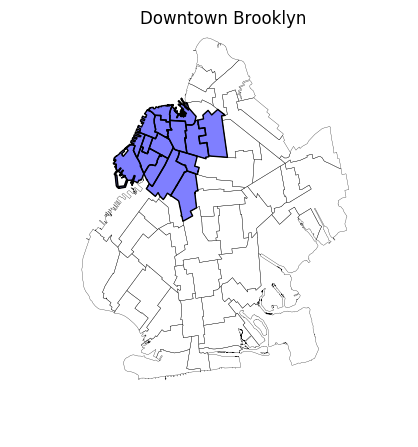

In [25]:
fig, ax = plt.subplots(1, figsize = (4,5))
taxi_zones[taxi_zones.borough == 'Brooklyn'].plot(ax = ax, color = 'white', linewidth =0.2)
taxi_zones[taxi_zones['LocationID'].isin(bk_d)].plot(ax = ax, color = 'blue')
plt.axis('off')
plt.title('Downtown Brooklyn')
plt.legend(loc='best')

In [26]:
n_predict = 486
extrapolation = fourierExtrapolation(yp_bk_d_ts_grp[yp_bk_d_ts_grp.index < '2015-01-01']['pickup_count'], n_predict)

(extrapolation[730:1096]).sum()

1754221.1799997543

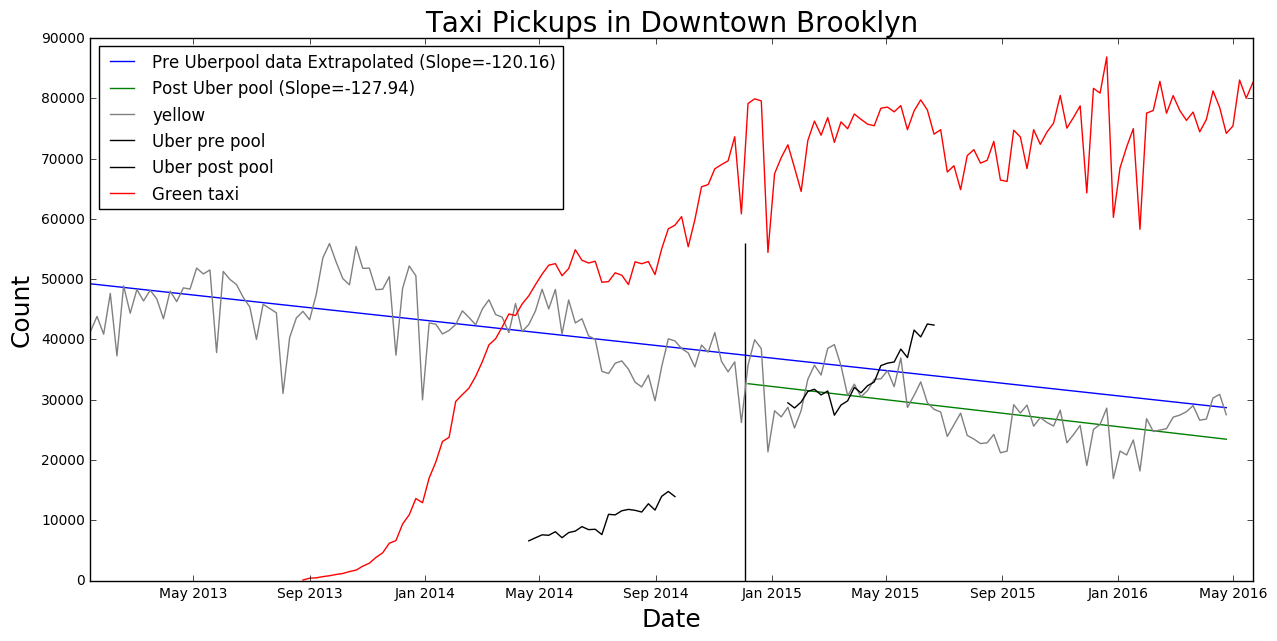

In [105]:
a1,b1=polyfit(range(len(yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index < '2014-12-04')])), 
              yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index < '2014-12-04')].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yp_bk_d_ts_grp)))


a2,b2=polyfit(range(len(yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index >= '2014-12-04') ])), 
              yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index >= '2014-12-04')].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index >= '2014-12-04')])))

plt.figure(figsize=(15,7))
plt.plot(yp_bk_d_ts_grp.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
plt.plot(yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index >= '2014-12-04')].index, linreg2, label = "Post Uber pool (Slope="+str(round(a2,2))+")")


plt.plot(yp_bk_d_ts_grp.index, yp_bk_d_ts_grp.pickup_count, label = 'yellow', c ='grey')
plt.plot(uber_pre_dwn_grp.index, uber_pre_dwn_grp.counts, label = 'Uber pre pool', c = 'black')
plt.plot(uber_post_dwn_grp.index, uber_post_dwn_grp.counts, label = 'Uber post pool', c = 'black')
plt.plot(gp_dwn_grp.index, gp_dwn_grp.pickup_count, label='Green taxi') 
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yp_bk_d_ts_grp.pickup_count)+ 10)
plt.xlabel("Date", size = 18)
plt.ylabel("Count", size = 18)
plt.title('Taxi Pickups in Downtown Brooklyn', size=20)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend(loc='best')

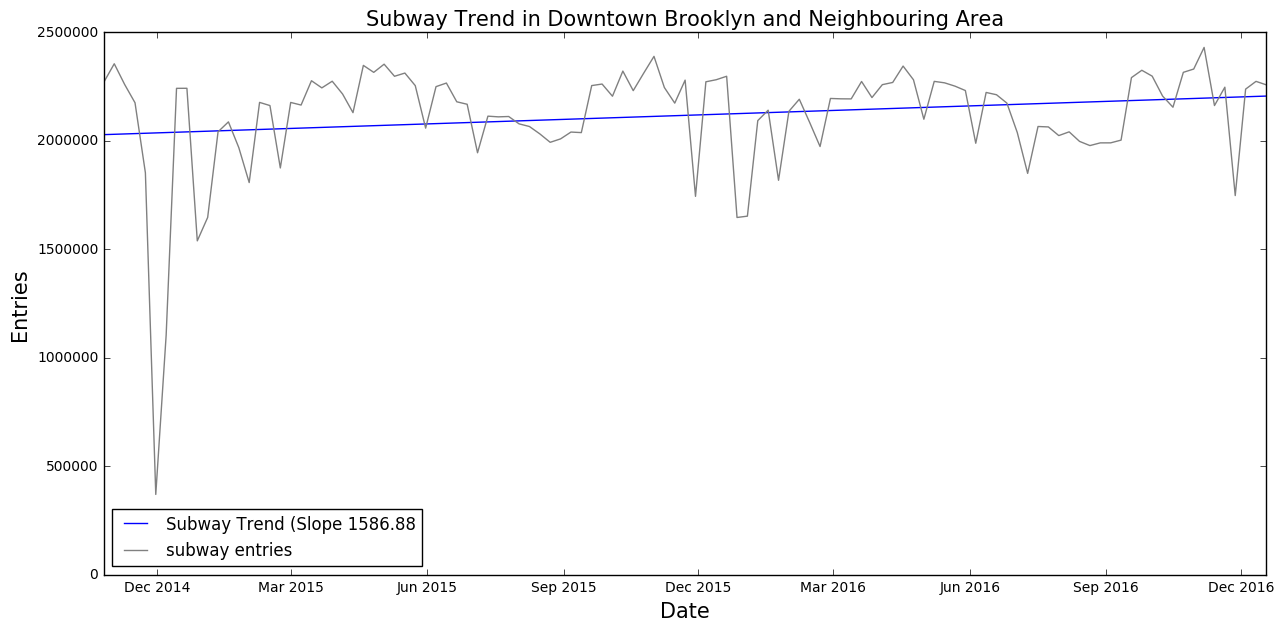

In [161]:
a1,b1=polyfit(range(len(subway_bk_d_grp)), 
              subway_bk_d_grp.loc[:,'ENTRIES_DIFF'],1)
linreg1=polyval([a1,b1],range(len(subway_bk_d_grp)))

plt.figure(figsize=(15,7))
plt.plot(subway_bk_d_grp.index, linreg1, label = "Subway Trend (Slope " + str(round(a1,2)))
plt.plot(subway_bk_d_grp.index, subway_bk_d_grp.ENTRIES_DIFF, label = 'subway entries', c ='grey')
plt.xlabel('Date', size = 15)
plt.ylabel('Entries', size = 15)
plt.title('Subway Trend in Downtown Brooklyn and Neighbouring Area', size = 15)
plt.legend(loc='best')

In [14]:
bus = pd.DataFrame({'year':['2013-12-31', '2014-12-31', '2015-12-31'], 'ridership':[148571190, 139957832, 133326664]})

In [15]:
bus.year = pd.to_datetime(bus.year)

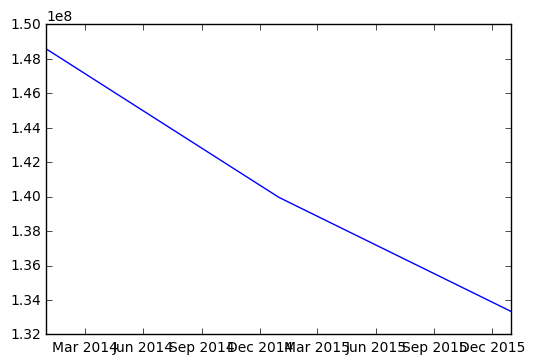

In [17]:
plt.plot(bus.year, bus.ridership)

In [28]:
x = (yp_bk_d_ts_grp[(yp_bk_d_ts_grp.index < '2014-12-04')].loc[:,'pickup_count'])

p, cov=polyfit(range(len(x)), x,1,cov=True)
# linreg1=polyval([a1,b1],range(len(yp_grp_ts)))

perr = np.sqrt(np.diag(cov))

perr

array([   0.32861794,  133.04650976])

In [54]:
x = (uber_pre_dwn_grp['counts'])

p, cov=polyfit(range(len(x)), x,1,cov=True)
# linreg1=polyval([a1,b1],range(len(yp_grp_ts)))

perr = np.sqrt(np.diag(cov))

perr

array([  0.45796297,  48.18777414])

In [31]:
bk_br = [11, 14, 22, 26, 67, 111, 227, 228]

In [32]:
bk_br_lower = yp[(yp.borough == 'Brooklyn') & yp.locationid.isin(bk_br)]

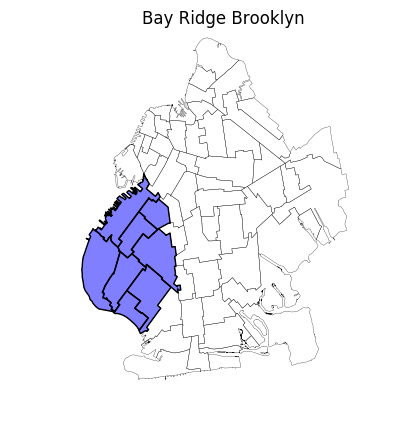

In [33]:
fig, ax = plt.subplots(1, figsize = (4,5))

taxi_zones[taxi_zones.borough == 'Brooklyn'].plot(ax = ax, color = 'white', linewidth =0.2)
taxi_zones[taxi_zones.LocationID.isin(bk_br)
          ].plot(ax = ax, color = 'blue')
plt.axis('off')
plt.title('Bay Ridge Brooklyn')
plt.legend(loc='best')

In [34]:
bk_br_lower = bk_br_lower.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

In [36]:
subway_bk_br_lower = subway[subway.LocationID.isin(bk_br)] 
subway_bk_br_lower.head()

,DATE,LocationID,EXITS_DIFF,ENTRIES_DIFF,borough
2,2014-10-11,14,8609.0,16793.0,Brooklyn
6,2014-10-11,22,15482.0,26056.0,Brooklyn
9,2014-10-11,26,4234.0,7448.0,Brooklyn
123,2014-10-11,227,13153.0,14114.0,Brooklyn
124,2014-10-11,228,17099.0,26224.0,Brooklyn


In [37]:
subway_bk_br_lower_grp = subway_bk_br_lower.set_index('DATE').groupby([pd.TimeGrouper('A')]).agg({'ENTRIES_DIFF':'sum'})

In [38]:
subway_bk_br_lower_grp

,ENTRIES_DIFF
DATE,
2014-12-31,11127347.0
2015-12-31,49783455.0
2016-12-31,52917846.0


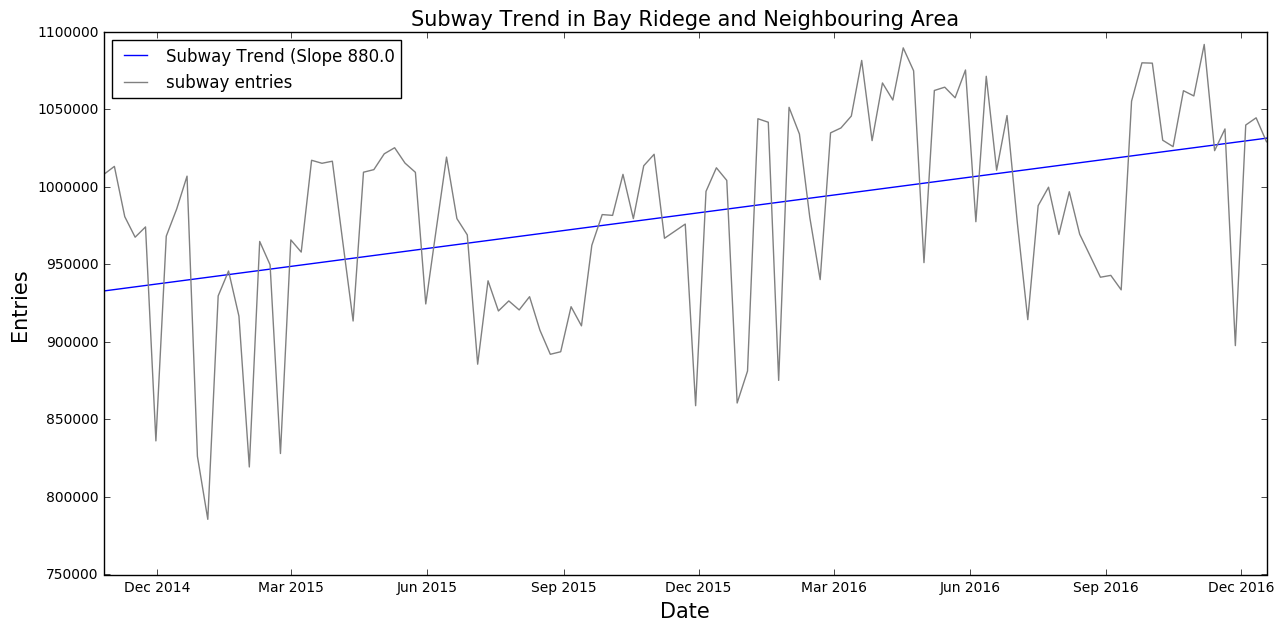

In [39]:
subway_bk_br_lower_grp = subway_bk_br_lower.set_index('DATE').groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[2:-2]

a1,b1=polyfit(range(len(subway_bk_br_lower_grp)), 
              subway_bk_br_lower_grp.loc[:,'ENTRIES_DIFF'],1)
linreg1=polyval([a1,b1],range(len(subway_bk_br_lower_grp)))

plt.figure(figsize=(15,7))
plt.plot(subway_bk_br_lower_grp.index, linreg1, label = "Subway Trend (Slope " + str(round(a1,2)))
plt.plot(subway_bk_br_lower_grp.index, subway_bk_br_lower_grp.ENTRIES_DIFF, label = 'subway entries', c ='grey')
plt.xlabel('Date', size = 15)
plt.ylabel('Entries', size = 15)
plt.title('Subway Trend in Bay Ridege and Neighbouring Area', size = 15)
plt.legend(loc='best')

In [40]:
uber_pre_lower = uber_pre[uber_pre.LocationID.isin(bk_br)]
uber_post_lower = uber_post[uber_post.LocationID.isin(bk_br)]

In [41]:
uber_pre_lower.head(2)

,Date,LocationID,counts,borough
7,2014-04-01,14,18,Brooklyn
11,2014-04-01,22,4,Brooklyn


In [42]:
uber_pre_lower_grp = uber_pre_lower.set_index('Date').groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[2:-2]
uber_post_lower_grp = uber_post_lower.set_index('Date').groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[2:-2]

In [43]:
gp_br = gp[gp.locationid.isin(bk_br)]

In [44]:
gp_br.head(2)

,date,locationid,trip_distance,pickup_count,LocationID,borough
6,2014-01-01,11,1.902500,4,11,Brooklyn
7,2014-01-01,14,5.649063,32,14,Brooklyn


In [50]:
gp_br_grp = gp_br.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

In [52]:
n_predict = 486
extrapolation = fourierExtrapolation(bk_br_lower[bk_br_lower.index < '2015-01-01']['pickup_count'], n_predict)

(extrapolation[730:1096]).sum()

47268.997227322259

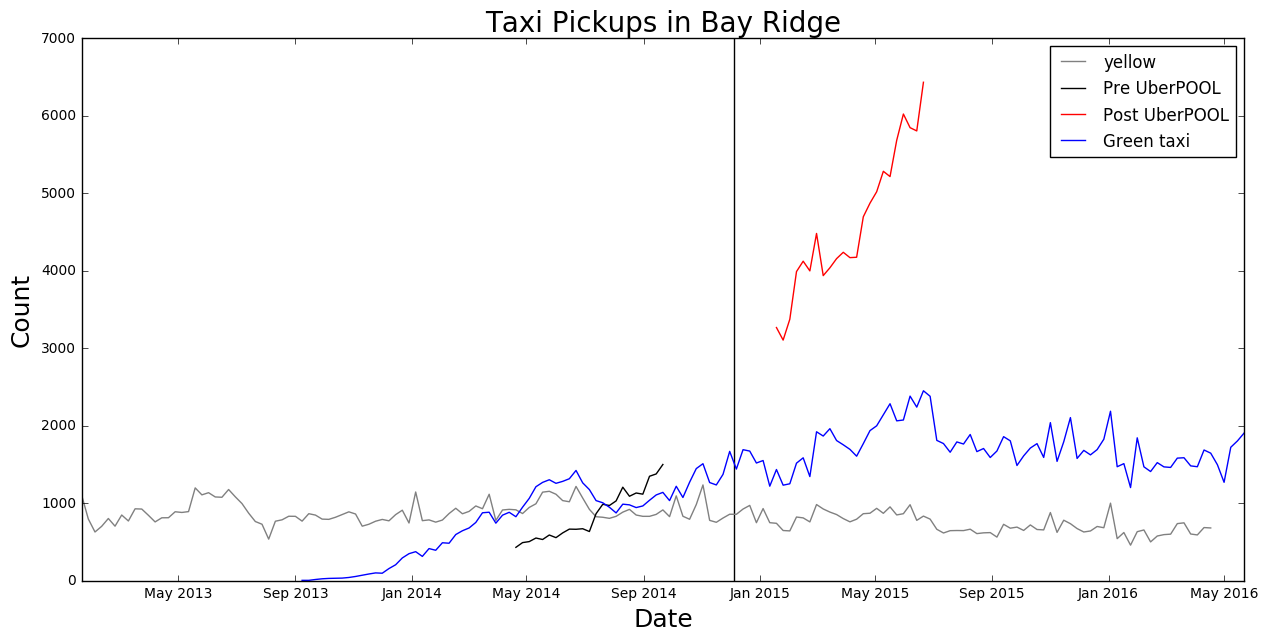

In [137]:
a1,b1=polyfit(range(len(bk_br_lower[(bk_br_lower.index < '2014-12-04')])), 
              bk_br_lower[(bk_br_lower.index < '2014-12-04')].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(bk_br_lower)))


a2,b2=polyfit(range(len(bk_br_lower[(bk_br_lower.index >= '2014-12-04') ])), 
              bk_br_lower[(bk_br_lower.index >= '2014-12-04')].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(bk_br_lower[(bk_br_lower.index >= '2014-12-04')])))

plt.figure(figsize=(15,7))
# plt.plot(bk_br_lower.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
# plt.plot(bk_br_lower[(bk_br_lower.index >= '2014-12-04')].index, linreg2, label = "Post Uber pool (Slope="+str(round(a2,2))+")")


plt.plot(bk_br_lower.index, bk_br_lower.pickup_count, label = 'yellow', c ='grey')
plt.plot(uber_pre_lower_grp.index, uber_pre_lower_grp.counts, label = 'Pre UberPOOL', c = 'black')
plt.plot(uber_post_lower_grp.index, uber_post_lower_grp.counts, label = 'Post UberPOOL', c = 'red')
plt.plot(gp_br_grp.index, gp_br_grp.pickup_count, label='Green taxi') 
plt.vlines(x='12-04-2014', ymin= 0, ymax= 7000)
plt.xlabel("Date", size = 18)
plt.ylabel("Count", size = 18)
plt.title('Taxi Pickups in Bay Ridge', size=20)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend(loc='best')

In [138]:
uber_pre_lower_grp = uber_pre_lower.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})
uber_post_lower_grp = uber_post_lower.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})

In [139]:
n_predict = 272
extrapolation = fourierExtrapolation(uber_pre_lower_grp['counts'], n_predict)

In [140]:
extrapolation[275:].sum()

65693.617529586438

In [141]:
uber_post_lower_grp['counts'].sum()

118335

In [49]:
x = (bk_br_lower[(bk_br_lower.index < '2014-12-04')].loc[:,'pickup_count'])

p, cov=polyfit(range(len(x)), x,1,cov=True)
# linreg1=polyval([a1,b1],range(len(yp_grp_ts)))

perr = np.sqrt(np.diag(cov))

perr

array([ 0.00968296,  3.92031122])

In [53]:
x = (uber_pre_lower_grp['counts'])

p, cov=polyfit(range(len(x)), x,1,cov=True)
# linreg1=polyval([a1,b1],range(len(yp_grp_ts)))

perr = np.sqrt(np.diag(cov))

perr

array([  3.00786991,  38.63678854])